# Evaluate the turbulent sink and source terms in the mixed layer

$$
\frac{1}{2}\frac{\partial u'^2}{\partial t} = \epsilon - \langle u'w'\rangle\frac{\partial u}{\partial z}-J_b + \langle u'p'\rangle + \langle w'p'\rangle
$$
where $\langle u'w'\rangle\frac{\partial u}{\partial z}$ can be approximated with $u^{*3} (kz)^{-1}$. All of these terms have units of buoyancy flux [W/g].

In [77]:
%matplotlib inline

import sys
sys.path.append('../src/')

import glob
import warnings

import numpy as np
import pandas as pd
import xarray as xr

from scipy.optimize import curve_fit, minimize

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray

from sklearn.linear_model import LinearRegression

from epsilon_tools import *
from tools import str2date, avg_funs

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='poster', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

## Compute Monin-Obhukov scale (from heat fluxes and winds only)

Monin Obukho scale is defined as $$L \equiv \frac{-u^{*3}}{\kappa B_0}$$\
with friction velocity $u^{*} = \sqrt{\frac{\tau}{\rho}}$,\
net buoyancy flux at the surface $B_0$,\
and van Karman constant $\kappa = 0.4$.

Since reanalysis heat flux $Q_{net}$ is in [W/m2], it needs to be converted to buoyancy flux in [W/kg] by $B_0 = -g \alpha_T Q_{net}/(\rho c_p)$.

In [191]:
dat = xr.open_dataset('../data/ml/ww_7781a_1h_2Tf.nc')
met = xr.open_dataset('../data/xarray/qc_ww_7781a.nc')
dat = dat.sel( time = slice('9-15-2016','12-10-2016') )
met = met.sel( mettime = slice('9-15-2016','12-10-2016') )
met = met.sel( time = slice('9-15-2016','12-10-2016') )
emp = xr.open_dataset('../data/CFS/croppped_emp_field.nc')

In [192]:
met['S0'] = ('time',met.S.where(met.z>met.mld).mean(dim='z'))
met['epz'] = ('time',met.eps.where(met.z>met.mld).mean(dim='z'))

In [193]:
flot = xr.open_dataset('../data/xarray/qc_7781a.nc')
import gsw
cp = gsw.cp_t_exact(flot.isel(z=2).S.mean(),flot.isel(z=2).T.mean(),0)
alphaT = gsw.alpha(flot.isel(z=2).S.mean(),flot.isel(z=2).T.mean(),0)
betaS = gsw.beta(flot.isel(z=2).S.mean(),flot.isel(z=2).T.mean(),0)

In [194]:
rho0=1025
g = 9.81
met['tau'] = 0.5*np.sqrt( met.tx**2 + met.ty**2 )
met['uprime'] = (np.sqrt( met.tau/rho0))**3


met['mld'] = ('mettime', met.mld.dropna('time').interp(time=met.mettime) )
met['S0'] = ('mettime', met.S0.dropna('time').interp(time=met.mettime) )
met['epz'] = ('mettime', met.epz.dropna('time').interp(time=met.mettime) )
met['lon'] = ('mettime', met.lon.dropna('time').interp(time=met.mettime) )
met['lat'] = ('mettime', met.lat.dropna('time').interp(time=met.mettime) )

In [195]:
resample = emp.sortby('time').resample(time='1h').mean()

In [196]:
resample = resample.rename({'time':'mettime'})
sub = resample.EMP.interp_like(met) # interpolates onto floats time

In [197]:
collect = []
for t in sub.mettime:
    temp1 = sub.sel(mettime=t)
    temp2 = met.sel(mettime=t)
    
    if ~temp2.lon.isnull() & ~temp2.lat.isnull():
        collect.append(temp1.interp(lon=temp2.lon,lat=temp2.lat))
#     else:
#         collect.append(np.nan)
# sub.interp()

In [198]:
collect = xr.concat(collect,dim='mettime')
met['emp'] = collect
met['emp'] = met.emp/(100*86400)

In [199]:
met['BQ'] = g*alphaT*met.Qnet/(cp*rho0)
met['BEP'] = g*betaS*met.emp*met.S0/(1-met.S0/1000)
met['B'] = met.BQ + met.BEP
met['MO'] = -met.uprime/(0.4*met.B)
met['MO_MLD'] = met.MO/met.mld

## Estimate how large the (E-P) contribution to Jb would be:

The buoyancy flux in [W/kg] is given by
$$
B = \frac{g\alpha Q}{c_p\rho} + \frac{g\beta(E-P)S}{1-\frac{S}{1000}}
$$
where Q is the upward heat flux [Wm$^{-2}$], evaporation minus precipitation(E-P) in [m/s], S the surface salinity.

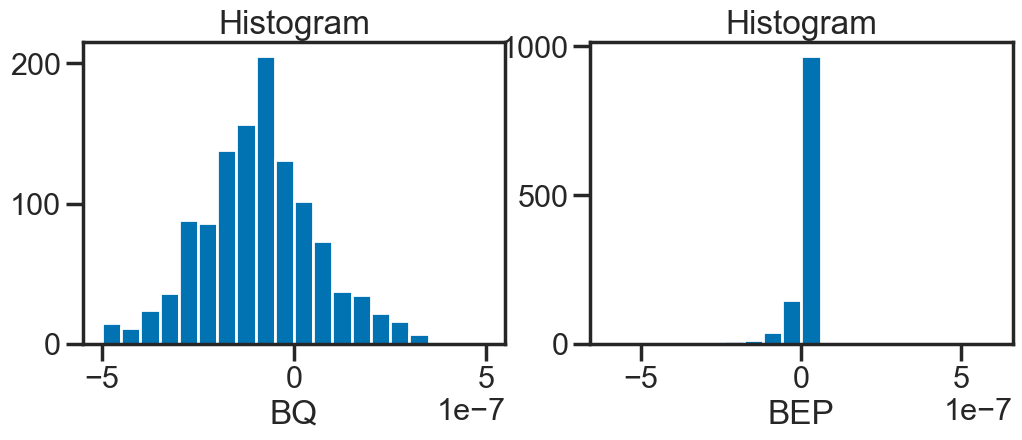

In [200]:
f,ax = plt.subplots(1,2, figsize=(12,4))
met.BQ.plot.hist(ax=ax[0],range=(-5e-7,5e-7), bins=20)
met.BEP.plot.hist(range=(-6e-7,6e-7),ax=ax[1], bins=20);

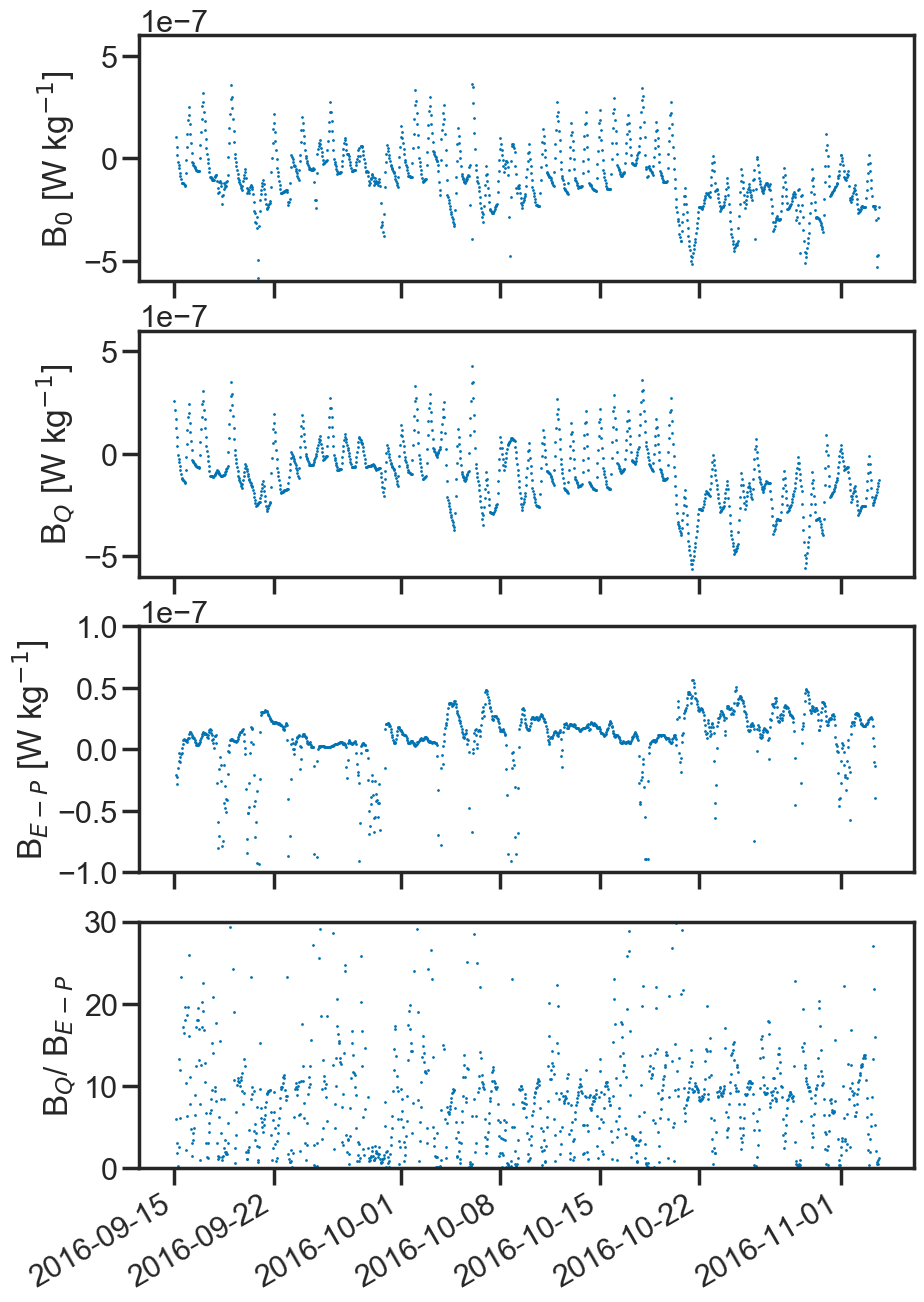

In [201]:
f,ax=plt.subplots(4,1,sharex=True, figsize=(10,15))
# met['uprime'].plot(ax=ax[0],lw=0,marker='.',ms=2)
# ax[0].set_xlabel(None)
# ax[0].set_ylabel(r'u*')
# ax[0].set_ylim(0,2e-6)

met['B'].plot(ax=ax[0],lw=0,marker='.',ms=2)
ax[0].set_xlabel(None)
ax[0].set_ylabel(r'B$_0$ [W kg$^{-1}$]')
ax[0].set_ylim(-6e-7,6e-7)

met['BQ'].plot(ax=ax[1],lw=0,marker='.',ms=2)
ax[1].set_xlabel(None)
ax[1].set_ylabel(r'B$_Q$ [W kg$^{-1}$]')
ax[1].set_ylim(-6e-7,6e-7)

met.BEP.plot(ax=ax[2],lw=0,marker='.',ms=2)
ax[2].set_xlabel(None)
ax[2].set_ylabel(r'B$_{E-P}$ [W kg$^{-1}$]');
ax[2].set_ylim(-1e-7,1e-7);

met['ratio'] = np.abs( met.BQ/met.BEP )
met.ratio.plot(ax=ax[3],lw=0,marker='.',ms=2)
ax[3].set_xlabel(None)
ax[3].set_ylabel(r'B$_Q$/ B$_{E-P}$');
ax[3].set_ylim(0,30);

plt.savefig('../figures/buoyancy_fluxes.pdf')

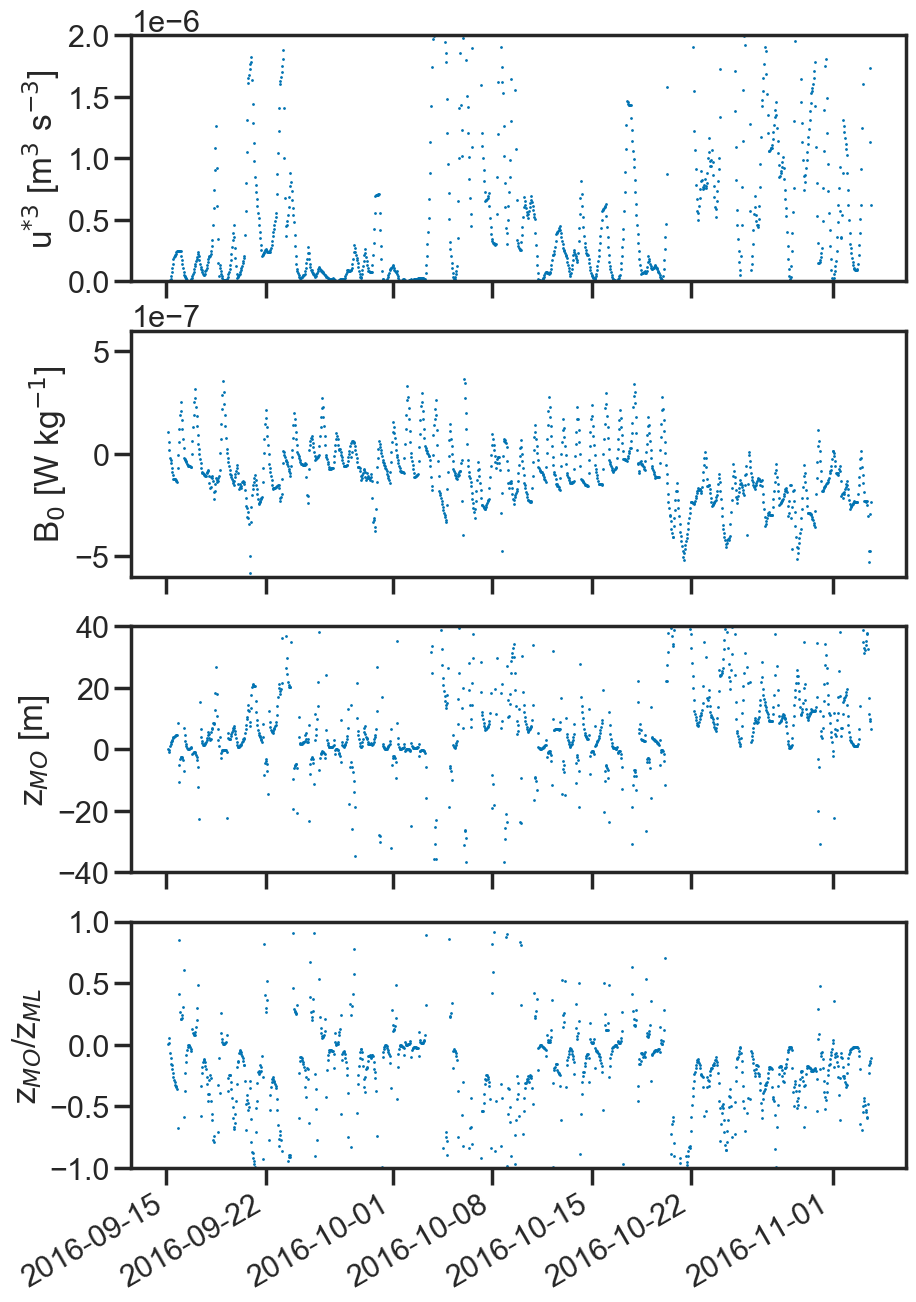

In [202]:
f,ax=plt.subplots(4,1,sharex=True, figsize=(10,15))
met['uprime'].plot(ax=ax[0],lw=0,marker='.',ms=2)
ax[0].set_xlabel(None)
ax[0].ticklabel_format(axis='y',style='sci',scilimits=(0,-7))
ax[0].set_ylabel(r'u$^{*3}$ [m$^3$ s$^{-3}$]')
ax[0].set_ylim(0,2e-6)

met['B'].plot(ax=ax[1],lw=0,marker='.',ms=2)
ax[1].set_xlabel(None)
ax[1].set_ylabel(r'B$_0$ [W kg$^{-1}$]')
# ax[0].ticklabel_format(axis='y',style='sci',scilimits=(-6,6))
ax[1].set_ylim(-6e-7,6e-7)

met.MO.plot(ax=ax[2],lw=0,marker='.',ms=2)
ax[2].set_xlabel(None)
ax[2].set_ylim(-40,40);
ax[2].set_ylabel(r'z$_{MO}$ [m]')

met.MO_MLD.plot(ax=ax[3],lw=0,marker='.',ms=2)
ax[3].set_xlabel(None)
ax[3].set_ylim(-1,1);
ax[3].set_ylabel(r'z$_{MO}$/z$_{ML}$');

plt.savefig('../figures/monin_obukhov.pdf')

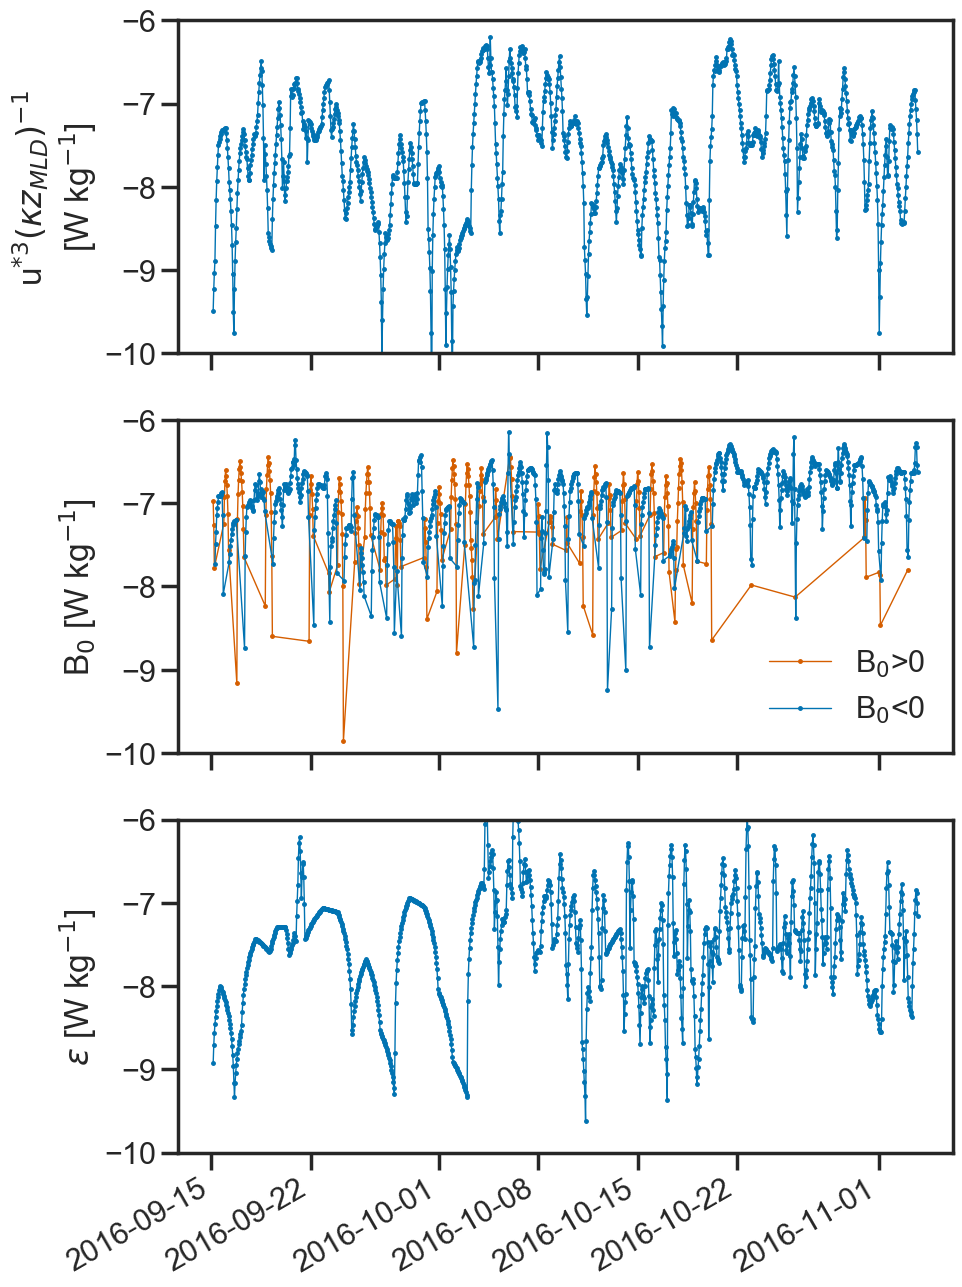

In [203]:
f,ax=plt.subplots(3,1,sharex=True, figsize=(10,15))


met['uprime_kz'] = met.uprime/(0.4*met.mld)
met['uprime_kz'].dropna(dim='mettime').pipe(np.abs).pipe(np.log10).plot(ax=ax[0],lw=1,marker='.',ms=5)
ax[0].set_xlabel(None)
# ax[0].ticklabel_format(axis='y',style='sci',scilimits=(0,-7))
ax[0].set_ylabel(r'u$^{*3} (\kappa z_{MLD})^{-1}$'+'\n'+r'[W kg$^{-1}$]')
ax[0].set_ylim(-10,-6)
# ax[1].set_ylim(-6e-7,6e-7)

met.B.where(met.B>0).dropna(dim='mettime').pipe(np.abs).pipe(np.log10).plot(ax=ax[1],lw=1,marker='.',ms=5, color='r', label='B$_0$>0')
met.B.where(met.B<0).dropna(dim='mettime').pipe(np.abs).pipe(np.log10).plot(ax=ax[1],lw=1,marker='.',ms=5, color='b', label='B$_0$<0')
ax[1].set_xlabel(None)
ax[1].set_ylabel(r'B$_0$ [W kg$^{-1}$]')
# ax[0].ticklabel_format(axis='y',style='sci',scilimits=(-6,6))
ax[1].set_ylim(-10,-6)
ax[1].legend()

met.epz.dropna(dim='mettime').pipe(np.abs).pipe(np.log10).plot(ax=ax[2],lw=1,marker='.',ms=5)
# ax[2].ticklabel_format(axis='y',style='sci',scilimits=(0,-6))
ax[2].set_xlabel(None)
ax[2].set_ylim(-10,-6)
ax[2].set_ylabel(r'$\epsilon$ [W kg$^{-1}$]')


plt.savefig('../figures/turbulent_terms.pdf')

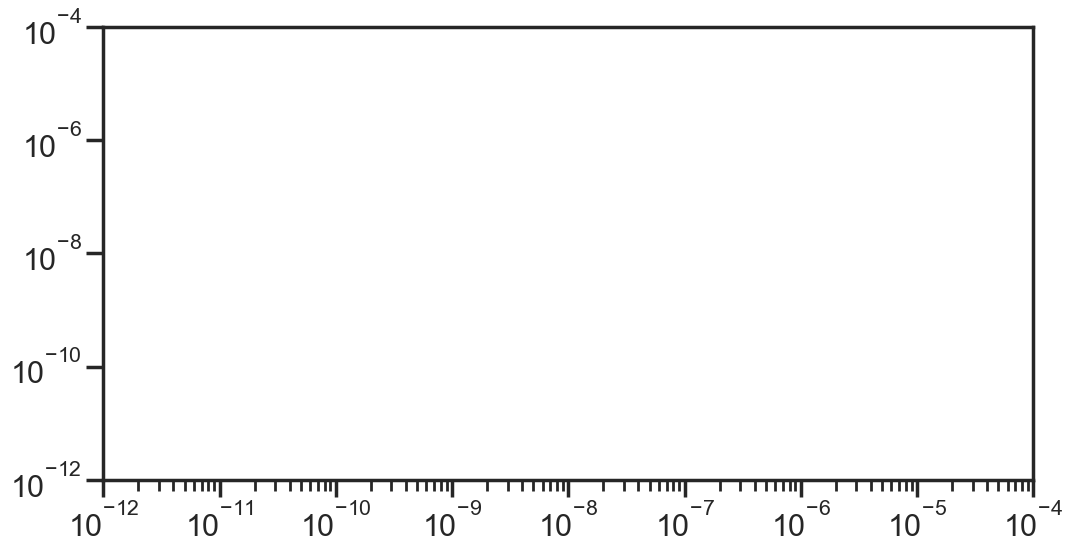

In [204]:
f,ax = plt.subplots(1,1)
ax.scatter(met['uprime_kz'],met['epz'],marker='+')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-12,1e-4)
ax.set_ylim(1e-12,1e-4);

In [205]:
met['uprime_kz']

<xarray.DataArray 'uprime_kz' (mettime: 2088)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * mettime  (mettime) datetime64[ns] 2016-09-15 ... 2016-12-10T23:00:00.000003
    lat      (mettime) float64 nan nan nan 39.56 39.56 ... nan nan nan nan nan
    lon      (mettime) float64 nan nan nan 148.0 148.0 ... nan nan nan nan nan

In [206]:
met['epz']

<xarray.DataArray 'epz' (mettime: 2088)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * mettime  (mettime) datetime64[ns] 2016-09-15 ... 2016-12-10T23:00:00.000003
    lat      (mettime) float64 nan nan nan 39.56 39.56 ... nan nan nan nan nan
    lon      (mettime) float64 nan nan nan 148.0 148.0 ... nan nan nan nan nan